In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Loading the ASL dataset

In [3]:
train_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [5]:
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

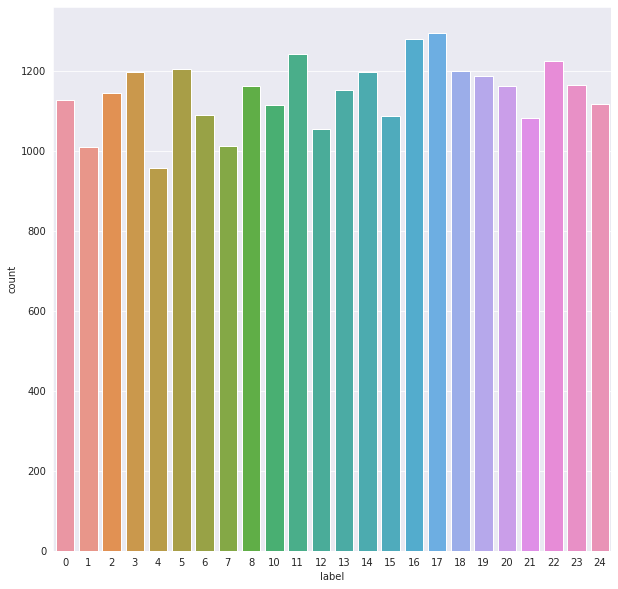

In [7]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [8]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [10]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [11]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [13]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

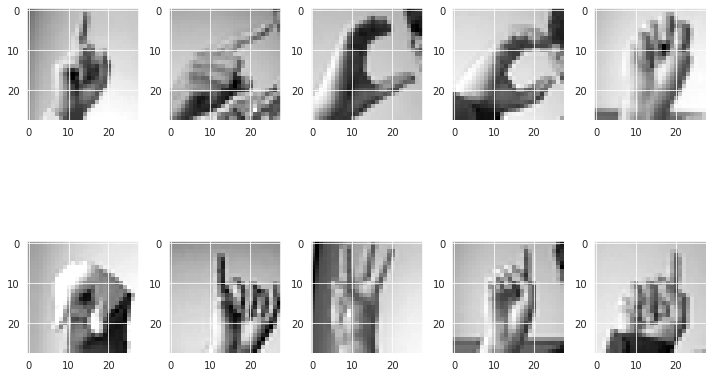

In [14]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

In [15]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training The Model

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [17]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)         

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 59s 277ms/step - loss: 1.0103 - accuracy: 0.6808 - val_loss: 3.4537 - val_accuracy: 0.1451
Epoch 2/20
215/215 [==============================] - 57s 263ms/step - loss: 0.2046 - accuracy: 0.9316 - val_loss: 0.8006 - val_accuracy: 0.7436
Epoch 3/20
215/215 [==============================] - 56s 262ms/step - loss: 0.1025 - accuracy: 0.9681 - val_loss: 0.0860 - val_accuracy: 0.9781
Epoch 4/20
215/215 [==============================] - 58s 268ms/step - loss: 0.0627 - accuracy: 0.9804 - val_loss: 0.0684 - val_accuracy: 0.9756
Epoch 5/20
215/215 [==============================] - 60s 280ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.1989 - val_accuracy: 0.9237

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
215/215 [==============================] - 62s 289ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0354 - val_accuracy: 0.9879
Epoch 7/20
215/215 [=============================

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y)[0]

**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1